<a href="https://colab.research.google.com/github/HiteshAI/time-series-analysis/blob/master/time_series_analysis_google_stock_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis with ARIMA
Get the google stock data

## Import libraries and get sample data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
!pip install pmdarima


In [2]:
#load the data
data = pd.read_csv('google_stock_data.csv')
print(data.columns)

data.tail()


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume
3804,2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1219.000000,1404100
3805,2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1205.099976,1273500
3806,2019-10-02,1196.979980,1196.979980,1171.290039,1176.630005,1176.630005,1615100
3807,2019-10-03,1180.000000,1189.060059,1162.430054,1187.829956,1187.829956,1621200
3808,2019-10-04,1191.890015,1211.439941,1189.170044,1209.000000,1209.000000,1021092


In [3]:
#preprocessing (since arima takes univariate series as input)
data.drop(['Date', 'Adj Close', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace=True)
data.head()

,Open
0,49.813286
1,50.316402
2,55.168217
3,55.412300
4,52.284027


In [4]:
data.tail()

,Open
3804,1220.969971
3805,1219.000000
3806,1196.979980
3807,1180.000000
3808,1191.890015


In [5]:
data.isnull().sum()
# data = data[data['Open'].notna()]

Open    0
dtype: int64

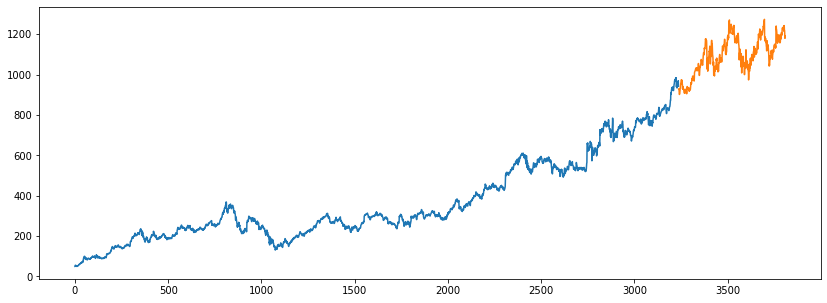

In [19]:
#divide into train and validation set
train = data[:int(0.85*(len(data)))]
valid = data[int(0.85*(len(data))):]

plt.figure(figsize=(14,5))
#plotting the data
train['Open'].plot()
valid['Open'].plot()


In [20]:
#building the model
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])




Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=21399.185, BIC=21435.678, Time=3.933 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=21397.217, BIC=21409.382, Time=0.105 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=21395.678, BIC=21413.924, Time=0.184 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=21395.832, BIC=21414.078, Time=0.508 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=21400.871, BIC=21406.953, Time=0.077 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=21396.030, BIC=21420.358, Time=0.565 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=21393.798, BIC=21418.127, Time=1.261 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=21397.867, BIC=21428.277, Time=1.142 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=21399.004, BIC=21429.415, Time=2.831 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=2

# **Visualization**

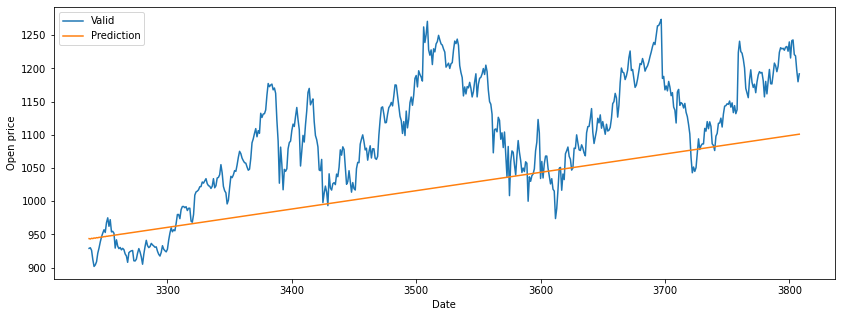

In [21]:
#plot the predictions for validation set
# plt.plot(train, label='Train')
plt.figure(figsize=(14,5))
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.ylabel('Open price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [22]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid,forecast))
print(rms)

99.26685217838688
